
# Clusterização de Pokemóns
## Integrantes:
Alessandra Blücher; 
Bruno Arthur Cesconetto; 
Dennis Zaramelo Felex -
2°C


## Introdução
<br>
Clusterização é a classificação não-supervisionada de dados, formando agrupamentos ou clusters. Ela representa uma das principais etapas de processos de análise de dados, denominada análise de clusters (JAIN et al., 1999).
</br>
<br>
A análise de clusters envolve, portanto, a organização de um conjunto de padrões em clusters, de acordo com alguma medida de similaridade.
</br>
<br>
### O método K-Means
<br>
O método K-Means clusteriza dados na tentativa de separar amostras em N grupos de igual variância, minimizando um critério denominado "inércia". Este algorítimo precisa de um número de clusters especifico e é eficiente ao utilizar-se uma grande quantidade de amostras, sendo utilizado em muitas aplicações e em diferentes áreas. 
</br>
<br>
O algorítimo do método K-Means divide uma amostra em K clusters diferentes, sendo cada um descrito por uma média <i>Uj</i> das variáveis separadas no clustercem questão. As médias são normalmente chamadas de "centróides" do cluster - na maioria das vezes, eles não são pontos que fazem parte das amostras, apesar de estarem no mesmo espaço. O algoritimo K-Means procura definir centroides os quais minimizem a o critério de "inercia".
</br>
<br>
A inércia é dada pela medida de quão coerentes são as variáveis postas num cluster internamente. 
</br>
<br>
•	A inércia assume que os clusters são convexos e isotrópicos, por mais que nem sempre sejam assim. Este coeficiente não é tão preciso quando os clusters forem vastos ou muito heterogêneos entre si (diferentes formas e tamanhos); 
</br>
<br>
•	A inercia não é uma métrica normalizada: sabe-se que valores baixos são os melhores e zeros constituem o caso ideal. Porém, em espaços com muitas dimensões, as distancias euclidianas tendem a se tornar “infladas”. Executar algoritmos de redução de dimensões antes de realizar a clusterização por K-Means, como o PCA, pode atenuar este problema e aumentar a velocidade dos cálculos.     
</br>

# Objetivos
<br>
O trabalho em questão buscará rotular os clusters resultantes de um dataframe de Pokémons clusterizado pelo método K-Means. Encontrando as características que definem cada cluster, é possível definir quais clusters contém os pokemóns mais fortes/fracos para as variáveis utilizadas, o que é útil para um jogador o qual quer escolher um Pokemón para uma dada ocasião: ele quer um Pokemón para ataques fulminantes? Quer se defender ao máximo? Ou quer apenas iniciar sua jornada no mundo Pokemón?
</br>

In [1]:
#importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #para gráficos estilizados
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

In [2]:
#lendo os dataframes
pokemons = pd.read_json('pokedex.json')
itens = pd.read_json('items.json')
habilidades = pd.read_json('skills.json')
tipos = pd.read_json('types.json')

In [3]:
#abrindo o dicionário contido em pokemons.base e adicionando novas colunas ao dataframe, uma para cada atributo do dicionário: 

#criando listas as quais armazenam os valores de um mesmo atributo
Attack= []
Defense = []
HP = []
SpAtk = []
SpDef = []
Speed = []

#percorrendo o dicionário e adicionando os valores às listas
for idx, row in pokemons['base'].iteritems(): #para cada index i, em cada linha dessa coluna base...
    l=row.keys()   #l é uma variável que contempla as chaves do dicionário

    if 'Attack' in l:   #quando a variável assume a chave ataque
        Attack.append(row['Attack']) #adicionamos seu valor a lista externa "ataque"
    else:
        Attack.append(None) #caso não haja, pass
    if 'Defense' in l:
        Defense.append(row['Defense'])
    else:
        Defense.append(None)
    if 'HP' in l:
        HP.append(row['HP'])
    else:
        HP.append(None)
    if 'Sp.Atk' in l:
        SpAtk.append(row['Sp.Atk'])
    else:
        SpAtk.append(None)
    if 'Sp.Def' in l:
        SpDef.append(row['Sp.Def'])
    else:
        SpDef.append(None) 
    if 'Speed' in l:
        Speed.append(row['Speed'])
    else:
        Speed.append(None)
    
#criando as novas colunas com os valores separados
pokemons['Attack']=Attack
pokemons['Defense']=Defense
pokemons['HP']=HP
pokemons['Sp.Atk']=SpAtk
pokemons['Sp.Def']=SpDef
pokemons['Speed']=Speed


In [4]:
#selecionando as colunas de interesse do dataframe
df = pokemons[['ename','type','Attack','Defense','HP','Sp.Atk','Sp.Def','Speed']]

#renomenando as colunas
df.columns = ['nome','tipo','ataque','defesa','HP','spe.atk','spe.def','velocidade']

df.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60
2,Venusaur,"[草, 毒]",82,83,80,100,100,80
3,Charmander,[炎],52,43,39,60,50,65
4,Charmeleon,[炎],64,58,58,80,65,80


## Explicação e Exemplos de aplicação de clusterização

Referência teórica para diferentes métodos de clusterzação: <br>
http://scikit-learn.org/stable/modules/clustering.html</br>

Exemplos de clusterização por K-means:<br> http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html</br>
<br>http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py</br>

# Verificando o número ideal de clusters

O método de distorção visa obter o número ideal de clusters ao se comparar o comportamento dos clusters para n clusters de uma mesma amostra. Quando a distorção passar a ter baixa variabilidade, mesmo aumentando o número de clusters, tem-se um número bom de divisões. Mais que isso torna os clusters basicamente singulares, ou seja, chegando a apenas 1 característica em específico os definindo e, menos que o ideal, deixa-os muito heterogêneos.

In [5]:
#guarando os dados em variáveis
v1 = df['ataque']
v2 = df['defesa']
v3 = df['HP']
v4 = df['spe.atk']
v5 = df['spe.def']
v6 = df['velocidade']

#as variáveis serão componentes de uma matriz
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

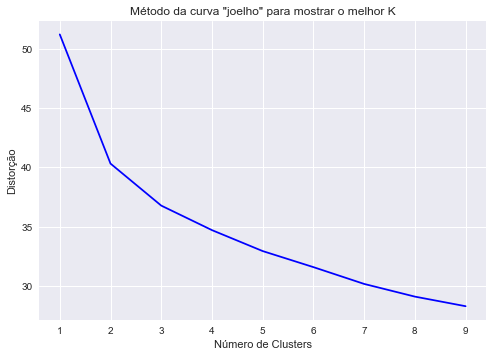

In [6]:
#kmeans determina o k ideal
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

#plotando 
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Distorção')
plt.title('Método da curva "joelho" para mostrar o melhor K')
plt.show()
 

Pelo gráfico acima, nota-se que 4 clusters é um número razoável para a divisão do dataframe de Pokemóns utilizado.

# Clusterizando o Dataframe

Será considerada na clusterização 4 variáveis: ataque, defesa, hp e velocidade; 
<br>
Foram escolhidas estas 4 características de cada Pokemón justamente por já serem variáveis quantitativas (são necessários valores numéricos para a clusterização que será realizada) e, por sinal, são 4 que definem habilidades muito recorrentes ao longo do jogo. Sendo assim, uma clusterização com base nestas nos dá um panorama geral do comportamento de um Pokemón em jogo: ele se sairá bem em ataques? Conseguirá se defender?
</br>
<br>
Como um gráfico 3D adimite apenas 3 variáveis, vamos "quebrar" a quarta variável em faixas e, a partir desta delimitação, será plotado o gráfico com os clusters, visualizando os pontos definidos pelas variáveis restantes dos Pokemóns os quais se encaixarem na delimitação em questão.</br>
<br>
A clusterização pelo método computacional aqui utilizado requer valores numéricos como parâmetros. Como a grande maioria das caracteríticas dos Pokemóns são qualitativas, seria necessária a conversão das mesmas em valores para tornar possível a clusterização da Pokedéx, utilizando tais características. Além disso, utilizar demasiadas características poderão tornar a interpretação dos resultados muito difícil, dado que os clusters resultantes poderiam ser muito heterogêneos ou muito específicos, além de não ser possível plotar gráficos com mais de 3 variáveis por vez, conforme mencionado anteriormente. 
</br>

In [7]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
df.loc[:,'cluster'] = kmeans.labels_ #indentificando cada um dos pokemóns por seu cluster numa nova coluna, em caso de futuro material de análise

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Função-Plot do fit realizado pelo Kmeans 

In [8]:
#função que plota o gráfico com os clusters


def showcluster(info, k, color, titulo, fig,q):
    ax = fig.add_subplot(q, projection='3d')
    ax.set_title(titulo)
    ax.set_xlabel(str(info[0].name))
    ax.set_ylabel(str(info[1].name))
    ax.set_zlabel(str(info[2].name))  
    for i in range(0,k):
        ax.scatter(info[0][df.cluster==i], info[1][df.cluster==i], info[2][df.cluster==i], marker='o', c=color[i])

colors = ['red','green','blue','purple']



# Clusterização com base na delimitação de uma das variáveis

### Para dado poder de ataque, como as outras três variáveis são distribuídas?

In [9]:
#ataques baixos
ataque40 = df[df.ataque<=40]

#variáveis que comporão a matriz para o fit (cada variável contém os valores de uma das colunas de interesse)
v1 = ataque40['ataque']
v2 = ataque40['defesa']
v3 = ataque40['HP']
v4 = ataque40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4) #arranjo numa matriz

In [10]:
kmeans = KMeans(n_clusters=4).fit(X) #clusterização realizada pelo módulo python
y_kmeans = kmeans.predict(X)
ataque40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
#ataques médios
ataque80 = df[(df['ataque']>40) & (df['ataque'] <= 80)]
#repetindo o processo de clusterização
v1 = ataque80['ataque']
v2 = ataque80['defesa']
v3 = ataque80['HP']
v4 = ataque80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [12]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataque80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
#ataques fortes
ataquef = df[df['ataque'] > 80]
#repetindo o processo de clusterização
v1 = ataquef['ataque']
v2 = ataquef['defesa']
v3 = ataquef['HP']
v4 = ataquef['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [14]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataquef.loc[:,'cluster'] = kmeans.labels_


C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


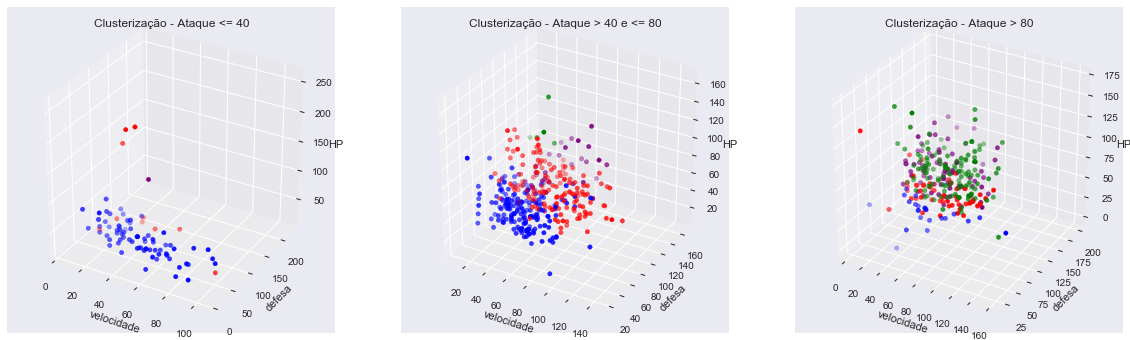

In [15]:
#área de plotagem
fig = plt.figure(figsize=[20,6])

plot = showcluster([ataque40.velocidade,ataque40.defesa,ataque40.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Ataque <= 40', fig,131)

plot = showcluster([ataque80.velocidade,ataque80.defesa,ataque80.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Ataque > 40 e <= 80',fig,132)

plot = showcluster([ataquef.velocidade,ataquef.defesa,ataquef.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Ataque > 80',fig,133)

plt.show()


### Separando os dataframes de ataque por clusters

In [16]:
#ataques fracos
a400 = ataque40[ataque40.cluster==0]
a401 = ataque40[ataque40.cluster==1]
a402 = ataque40[ataque40.cluster==2]
a403 = ataque40[ataque40.cluster==3]


In [17]:
#ataques médios
a800 = ataque80[ataque80.cluster==0]
a801 = ataque80[ataque80.cluster==1]
a802 = ataque80[ataque80.cluster==2]
a803 = ataque80[ataque80.cluster==3]


In [18]:
#ataques fortes
af0 = ataquef[ataquef.cluster==0]
af1 = ataquef[ataquef.cluster==1]
af2 = ataquef[ataquef.cluster==2]
af3 = ataquef[ataquef.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

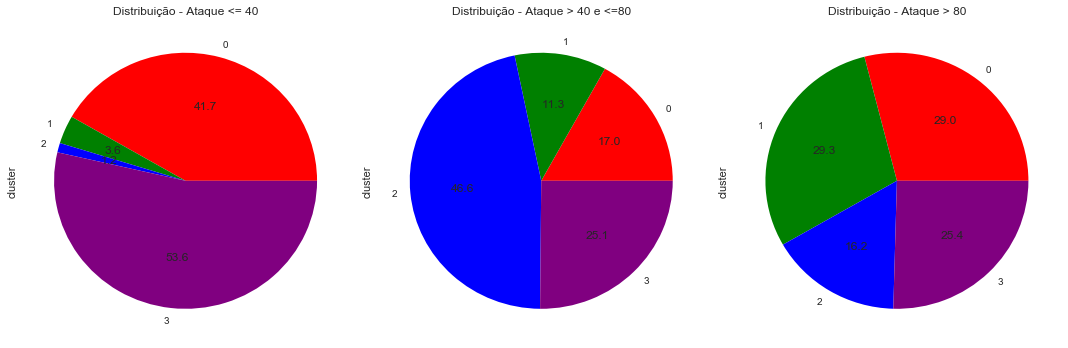

In [19]:
#value_counts
a40vc=(ataque40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
a80vc=(ataque80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
afvc = (ataquef.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = a40vc.plot(kind='pie',title='Distribuição - Ataque <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = a80vc.plot(kind='pie',title='Distribuição - Ataque > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = afvc.plot(kind='pie',title='Distribuição - Ataque > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


### Para dada capacidade de defesa, como as outras três variáveis são distribuídas?

In [20]:
#defesas baixas
defesa40 = df[df.defesa<=40]

#repetindo o processo de clusterização
v1 = defesa40['ataque']
v2 = defesa40['defesa']
v3 = defesa40['HP']
v4 = defesa40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [21]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesa40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
#defesas médias
defesa80 = df[(df['defesa']>40) & (df['defesa'] <= 80)]
#repetindo o processo de clusterização
v1 = defesa80['ataque']
v2 = defesa80['defesa']
v3 = defesa80['HP']
v4 = defesa80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [23]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesa80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
#defesas fortes
defesaf = df[df['defesa'] > 80]
#repetindo o processo de clusterização
v1 = defesaf['ataque']
v2 = defesaf['defesa']
v3 = defesaf['HP']
v4 = defesaf['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [25]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesaf.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


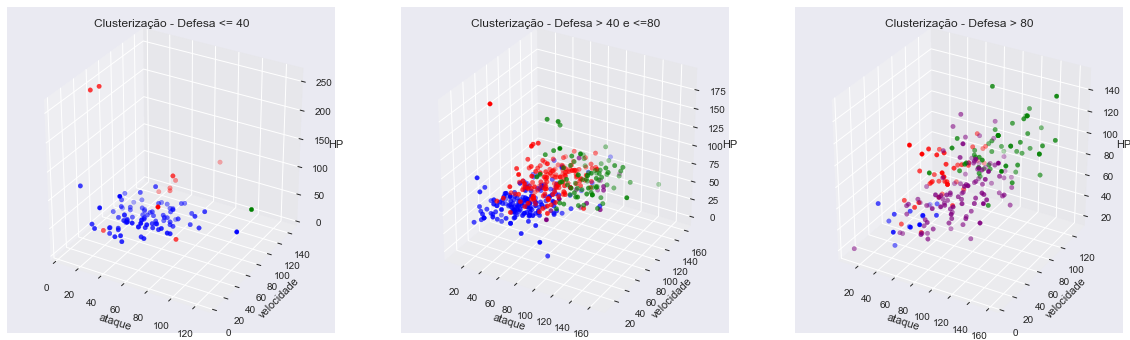

In [26]:
#área de plotagem
fig = plt.figure(figsize=[20,6])

plot = showcluster([defesa40.ataque,defesa40.velocidade,defesa40.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Defesa <= 40', fig,131)

plot = showcluster([defesa80.ataque,defesa80.velocidade,defesa80.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Defesa > 40 e <=80', fig,132)

plot = showcluster([defesaf.ataque,defesaf.velocidade,defesaf.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Defesa > 80', fig,133)

plt.show()

### Separando os dataframes de defesa por clusters

In [27]:
#defesas fracas
d400 = defesa40[defesa40.cluster==0]
d401 = defesa40[defesa40.cluster==1]
d402 = defesa40[defesa40.cluster==2]
d403 = defesa40[defesa40.cluster==3]


In [28]:
#defesas médias
d800 = defesa80[defesa80.cluster==0]
d801 = defesa80[defesa80.cluster==1]
d802 = defesa80[defesa80.cluster==2]
d803 = defesa80[defesa80.cluster==3]


In [29]:
#defesas fortes
df0 = defesaf[defesaf.cluster==0]
df1 = defesaf[defesaf.cluster==1]
df2 = defesaf[defesaf.cluster==2]
df3 = defesaf[defesaf.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

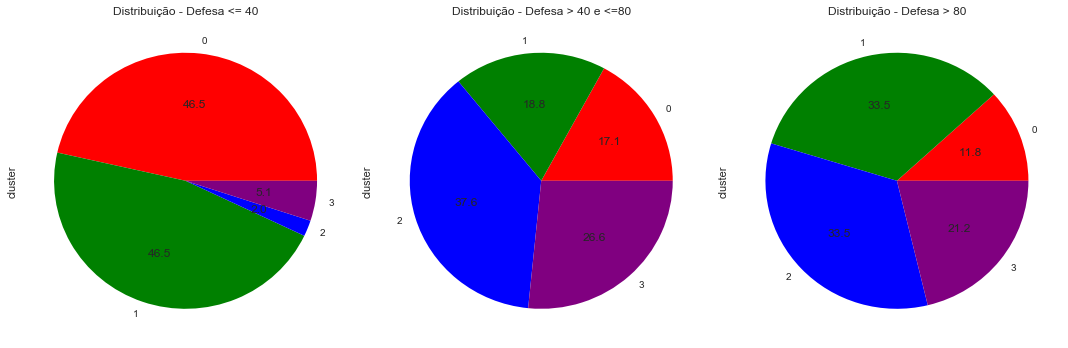

In [30]:
#value_counts
d40vc=(defesa40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
d80vc=(defesa80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
dfvc=(defesaf.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = d40vc.plot(kind='pie',title='Distribuição - Defesa <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = d80vc.plot(kind='pie',title='Distribuição - Defesa > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = dfvc.plot(kind='pie',title='Distribuição - Defesa > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


   ### Para dado nível de HP, como as outras três variáveis são distribuídas?

In [31]:
#HP baixo
HP40 = df[df.HP<=40]

#repetindo o processo de clusterização
v1 = HP40['ataque']
v2 = HP40['defesa']
v3 = HP40['HP']
v4 = HP40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [32]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HP40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
#HP médio
HP80 = df[(df['HP']>40) & (df['HP'] <= 80)]
#repetindo o processo de clusterização
v1 = HP80['ataque']
v2 = HP80['defesa']
v3 = HP80['HP']
v4 = HP80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [34]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HP80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [35]:
#HP alto
HPa = df[df['HP'] > 80]
#repetindo o processo de clusterização
v1 = HPa['ataque']
v2 = HPa['defesa']
v3 = HPa['HP']
v4 = HPa['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [36]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HPa.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


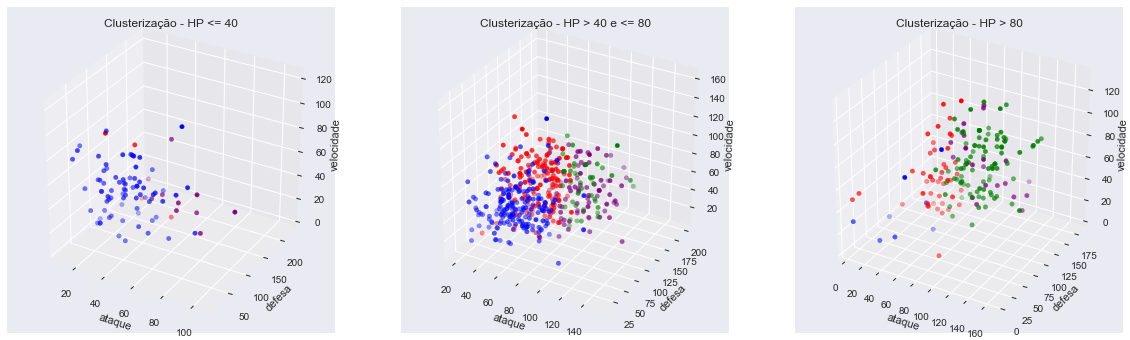

In [37]:
#área de plotagem

fig = plt.figure(figsize=[20,6])

plot = showcluster([HP40.ataque,HP40.defesa,HP40.velocidade],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - HP <= 40', fig,131)

plot = showcluster([HP80.ataque,HP80.defesa,HP80.velocidade],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - HP > 40 e <= 80', fig,132)

plot = showcluster([HPa.ataque,HPa.defesa,HPa.velocidade],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - HP > 80', fig,133)

plt.show()


### Separando os dataframes de HP por clusters

In [38]:
#HP Baixo
hp400 = HP40[HP40.cluster==0]
hp401 = HP40[HP40.cluster==1]
hp402 = HP40[HP40.cluster==2]
hp403 = HP40[HP40.cluster==3]


In [39]:
#HP Médio
hp800 = HP80[HP80.cluster==0]
hp801 = HP80[HP80.cluster==1]
hp802 = HP80[HP80.cluster==2]
hp803 = HP80[HP80.cluster==3]


In [40]:
#HP Alto
hpa0 = HPa[HPa.cluster==0]
hpa1 = HPa[HPa.cluster==1]
hpa2 = HPa[HPa.cluster==2]
hpa3 = HPa[HPa.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

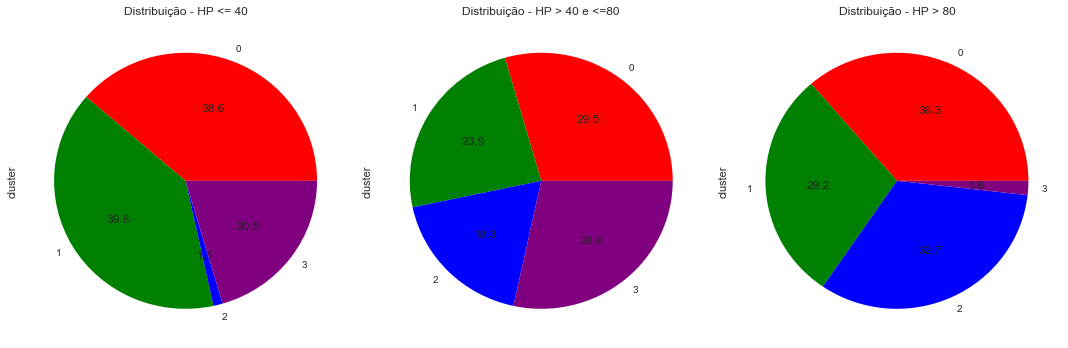

In [41]:
#value_counts
hp40vc=(HP40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
hp80vc=(HP80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
hpavc=(HPa.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = hp40vc.plot(kind='pie',title='Distribuição - HP <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = hp80vc.plot(kind='pie',title='Distribuição - HP > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = hpavc.plot(kind='pie',title='Distribuição - HP > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


### Para dada velocidade do pokemón, como as outras três variáveis são distribuídas?

In [42]:
#Velocidade baixa
V40 = df[df.velocidade<=40]

#repetindo o processo de clusterização
v1 = V40['ataque']
v2 = V40['defesa']
v3 = V40['HP']
v4 = V40['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [43]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
V40.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
#Velocidade média
V80 = df[(df['velocidade']>40) & (df['velocidade'] <= 80)]
#repetindo o processo de clusterização
v1 = V80['ataque']
v2 = V80['defesa']
v3 = V80['HP']
v4 = V80['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [45]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
V80.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
#Velocidade alta
Va = df[df['velocidade'] > 80]
#repetindo o processo de clusterização
v1 = Va['ataque']
v2 = Va['defesa']
v3 = Va['HP']
v4 = Va['velocidade']
X=np.array(list(zip(v1,v2,v3,v4))).reshape(len(v1),4)

In [47]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
Va.loc[:,'cluster'] = kmeans.labels_

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


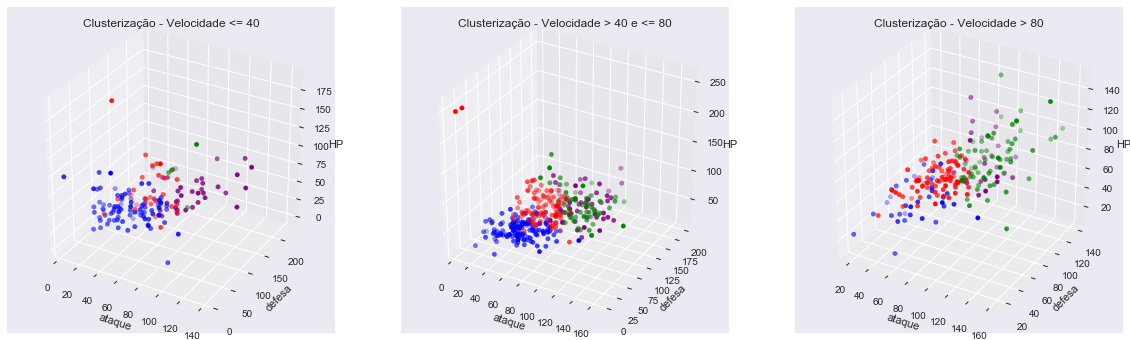

In [48]:
#área de plotagem
fig = plt.figure(figsize=[20,6])

plot = showcluster([V40.ataque,V40.defesa,V40.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Velocidade <= 40', fig,131)

plot = showcluster([V80.ataque,V80.defesa,V80.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Velocidade > 40 e <= 80', fig,132)

plot = showcluster([Va.ataque,Va.defesa,Va.HP],4,[['red'],['green'],['blue'],['purple']], 'Clusterização - Velocidade > 80', fig,133)

plt.show()

### Separando os dataframes de defesa por clusters

In [49]:
#Velocidades baixas
v400 = V40[V40.cluster==0]
v401 = V40[V40.cluster==1]
v402 = V40[V40.cluster==2]
v403 = V40[V40.cluster==3]


In [50]:
#Velocidades médias
v800 = V80[V80.cluster==0]
v801 = V80[V80.cluster==1]
v802 = V80[V80.cluster==2]
v803 = V80[V80.cluster==3]


In [51]:
#Velocidades altas
va0 = Va[Va.cluster==0]
va1 = Va[Va.cluster==1]
va2 = Va[Va.cluster==2]
va3 = Va[Va.cluster==3]


### Porcentagem dos Pokemóns clusterizados por cluster

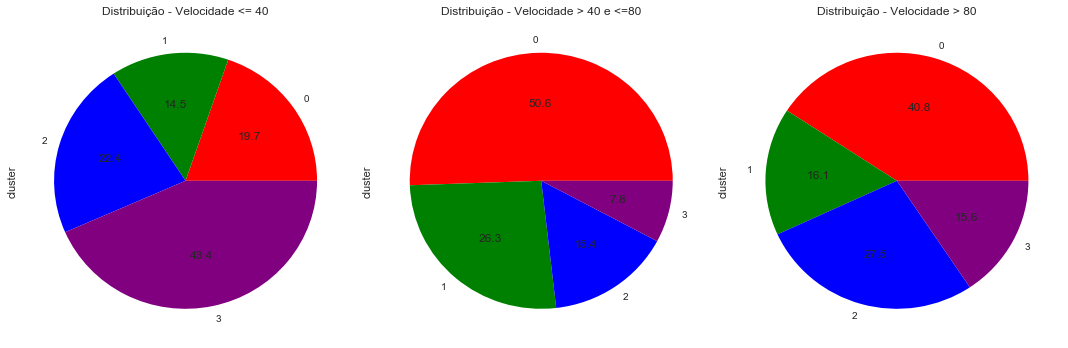

In [52]:
#value_counts
v40vc=(V40.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
v80vc=(V80.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)
vavc=(Va.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#área de plotagem

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = v40vc.plot(kind='pie',title='Distribuição - Velocidade <= 40',autopct='%.1f', colors=colors)

plt.subplot(132)
plot = v80vc.plot(kind='pie',title='Distribuição - Velocidade > 40 e <=80',autopct='%.1f', colors=colors)

plt.subplot(133)
plot = vavc.plot(kind='pie',title='Distribuição - Velocidade > 80',autopct='%.1f', colors=colors)

plt.tight_layout()
plt.show()


## Por fim, será analisado o dataframe completo, também filtrado por cluster:

In [53]:
#filtragem
cluster0 = df[df.cluster==0]
cluster1 = df[df.cluster==1]
cluster2 = df[df.cluster==2]
cluster3 = df[df.cluster==3]

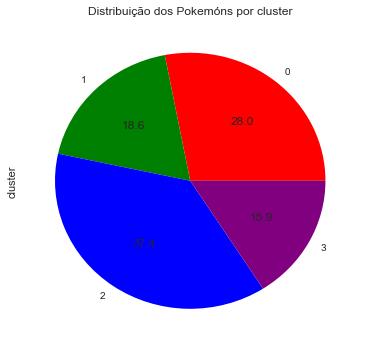

In [54]:
#value_counts
dfvc=(df.cluster.value_counts(sort=False, normalize=True)*100).round(decimals=2)

#plot
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plot = dfvc.plot(kind='pie',title='Distribuição dos Pokemóns por cluster',autopct='%.1f', colors=colors)
plt.tight_layout()
plt.show()

# Cluster 0

In [55]:
def deef(bloco):
    for i in bloco:
        print("media de ", i.name, ": ",i.mean())
        
    print('A média das variáveis utilizadas dos Pokémons do cluster é de:', (bloco[0].mean()+bloco[1].mean()+bloco[2].mean()+bloco[3].mean())/4)
    print('O desvio padrão de ataque dos Pokémons do cluster é de:', bloco[0].std())
    print('O desvio padrão de defesa dos Pokémons do cluster é de:', bloco[1].std())
    print('O desvio padrão de HP dos Pokémons do cluster é de:', bloco[2].std())
    print('O desvio padrão de velocidade dos Pokémons do cluster é de:', bloco[3].std())
    print('O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster é de:', (bloco[0].std()+bloco[1].std()+bloco[2].std()+bloco[3].std())/4)
    return 0

In [56]:
cluster0.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,0
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,0
4,Charmeleon,[炎],64,58,58,80,65,80,0
5,Charizard,"[炎, 飞行]",84,78,78,109,85,100,0
7,Wartortle,[水],63,80,59,65,80,58,0


In [57]:
deef([cluster0.ataque,cluster0.defesa,cluster0.HP,cluster0.velocidade]) #70

media de  ataque :  69.51980198019803
media de  defesa :  68.26237623762377
media de  HP :  75.39603960396039
media de  velocidade :  75.17821782178218
A média das variáveis utilizadas dos Pokémons do cluster é de: 72.0891089108911
O desvio padrão de ataque dos Pokémons do cluster é de: 16.49158096565222
O desvio padrão de defesa dos Pokémons do cluster é de: 17.54384614641227
O desvio padrão de HP dos Pokémons do cluster é de: 25.87823734949566
O desvio padrão de velocidade dos Pokémons do cluster é de: 27.364281486742012
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster é de: 21.81948648707554


0

# Cluster 1

In [58]:
cluster1.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
30,Nidoqueen,"[毒, 地上]",92,87,90,75,85,76,1
33,Nidoking,"[毒, 地上]",102,77,81,85,75,85,1
58,Arcanine,[炎],110,80,90,100,80,95,1
67,Machamp,[格斗],130,80,90,65,85,55,1
70,Victreebel,"[草, 毒]",105,65,80,100,70,70,1


In [59]:
deef([cluster1.ataque,cluster1.defesa,cluster1.HP,cluster1.velocidade]) # ataque muito alto

media de  ataque :  111.45522388059702
media de  defesa :  81.17910447761194
media de  HP :  93.94029850746269
media de  velocidade :  81.9776119402985
A média das variáveis utilizadas dos Pokémons do cluster é de: 92.13805970149254
O desvio padrão de ataque dos Pokémons do cluster é de: 18.865417966805893
O desvio padrão de defesa dos Pokémons do cluster é de: 18.82241934153794
O desvio padrão de HP dos Pokémons do cluster é de: 21.231187583976844
O desvio padrão de velocidade dos Pokémons do cluster é de: 23.610392263275106
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster é de: 20.632354288898945


0

# Cluster 2

In [60]:
cluster2.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,2
3,Charmander,[炎],52,43,39,60,50,65,2
6,Squirtle,[水],48,65,44,50,64,43,2
9,Caterpie,[虫],30,35,45,20,20,45,2
10,Metapod,[虫],20,55,50,25,25,30,2


In [61]:
deef([cluster2.ataque,cluster2.defesa,cluster2.HP,cluster2.velocidade]) # 50

media de  ataque :  53.68518518518518
media de  defesa :  49.5
media de  HP :  50.407407407407405
media de  velocidade :  54.18888888888889
A média das variáveis utilizadas dos Pokémons do cluster é de: 51.94537037037038
O desvio padrão de ataque dos Pokémons do cluster é de: 19.339679412536945
O desvio padrão de defesa dos Pokémons do cluster é de: 15.55079218388788
O desvio padrão de HP dos Pokémons do cluster é de: 14.560881696564856
O desvio padrão de velocidade dos Pokémons do cluster é de: 22.920532398971282
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster é de: 18.09297142299024


0

# Cluster 3

In [62]:
cluster3.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
27,Sandslash,[地上],100,110,75,45,55,65,3
46,Parasect,"[虫, 草]",95,80,60,60,80,30,3
61,Poliwrath,"[水, 格斗]",95,95,90,70,90,70,3
66,Machoke,[格斗],100,70,80,50,60,45,3
73,Geodude,"[岩石, 地上]",80,100,40,30,30,20,3


In [63]:
deef([cluster3.ataque,cluster3.defesa,cluster3.HP,cluster3.velocidade]) # defesa muito alta

media de  ataque :  92.48695652173913
media de  defesa :  113.29565217391304
media de  HP :  68.4695652173913
media de  velocidade :  57.76521739130435
A média das variáveis utilizadas dos Pokémons do cluster é de: 83.00434782608697
O desvio padrão de ataque dos Pokémons do cluster é de: 23.177183735716163
O desvio padrão de defesa dos Pokémons do cluster é de: 29.481773707336323
O desvio padrão de HP dos Pokémons do cluster é de: 19.815075662068924
O desvio padrão de velocidade dos Pokémons do cluster é de: 26.320337822040994
O desvio padrão médio das variáveis utilizadas dos Pokémons do cluster é de: 24.6985927317906


0

# Como são os Pokemóns?

Abaixo, há um exemplo de carta de um Pokemón. Há diversas características as quais compõem um deles. Neste projeto, utilizou-se apenas valores de ataque, defesa, HP e Velocidade, sendo alguns destes valores nem presentes nas cartas, mas apenas em versões eletrônicas do jogo. É relevante para o projeto o item Categoria (canto superior esquerdo da carta). As categorias nada mais são que os "níveis" dos Pokemóns, que saem do básico e passam pelos estágios 1 e 2, além de estágios especiais, os quais tornam os pokemóns muito poderosos. 

<img src='carta.jpg' >

Geralmente Pokémons básicos tem poucos pontos de saúde, custo de recuo e de energia baixos, e são cards comuns de serem encontrados (Valendo também para as versões eletrônicas)


<img src ='basicos.jpg'>

Um card estágio 1 é considerado como um card de evolução, evoluindo de um Pokémon básico correspondente. Normalmente Pokémons estágio 1 tem mais pontos de saúde, custo de recuo e de energia medianos, e são cards incomuns de serem encontrados.

<img src = 'stage1.jpg'>

Um card estágio 2 também é considerado como um card de evolução, evoluindo de um Pokémon estágio 1 correspondente. Normalmente Pokémons estágio 2 tem muitos pontos de saúde, custo de recuo e de energia altos, e são cards raros de serem encontrados.

<img src = 'stage 2.jpg'>

Os Pokémons EX são caracterizados por possuírem mais pontos de saúde do que os de outras categorias, além de terem ataques e habilidades mais poderosos.

<img src = 'EX.jpg'>

Os Pokémons LV. X são Pokémons mais fortes do que os normais, como se estivessem no Lv 100 nos jogos. Eles podem usar os ataques e habilidades de seu "estágio" anterior, tendo mais pontos de saúde e novos ataques. Porém, era necessário "evoluí-los" do Pokémon correspondente.

<img src = 'x.jpg'>

### Há diversas outras categorias presentes no jogo, porém, as 5 apresentadas acima já concedem uma boa base de como os pokemóns se caracterizam. 

### Apresentadas algumas categorias, vamos tentar descobrir como os pokemóns foram arranjados pela clusterização:

Num primeiro cluster, encontram-se os pokemons com a média das variáveis utilizadas para a clusterização em torno de 51 pontos e desvio-padrão médio de 18 pontos, o cluster com os menores valores médios presentes nesta análise.<br>
### Pokemóns básicos/iniciais, os mais fracos dos jogos.</br>

Observa-se, num outro cluster, Pokemóns com média das variáveis utilizadas para a clusterização em torno de 70 pontos e desvio padrão médio de 18 pontos. Ao comparar-se esses números com os dos outros clusters, este é um cluster de pokemóns em geral medianos, com ataque, defesa, HP e velocidade relativamente maiores (e equilibrados, em média) em relação aos Pokemóns iniciais.
<br>
### Pokemóns de estágio 1, em sua maioria, com alguns de estágio 2.

Num próximo, verifica-se uma média das variáveis utilizadas na clusterização em torno de 81 pontos com desvio-padrão médio de 23 pontos. Aqui, destaca-se a defesa, com média extremamente alta e uma velocidade tão baixa quanto a do cluster separado pelos valores médios mais baixos, em média. Os Pokemóns deste Cluster podem ser caracterizados, então, como "tanques". Ou seja, são os "grandões" que, além de suportarem muita pressão, possuem um ataque relativamente bom e são lentos.  
<br>
### Pokemóns fortes, podendo ser de estágio 2, X ou EX, desde que sejam caraterizados pela forte defesa e HP.
</br>

Num outro cluster encontram-se os Pokemóns com uma média das variáveis utilizadas para a clusterização em torno de 92 pontos, com poder de ataque alto e com o desvio padrão médio em torno de 21, ou seja, são Pokemóns de dano e HP notáveis e, mesmo assim, possuem defesa e velocidade acima da média. 
<br>
### Pokemóns fortes, podendo ser de estágio 2, X ou EX, desde que sejam caraterizados pelo forte ataque e HP.
</br>

Como observado, a rotulação dos clusters ficou relativamente rasa, exatamente por considerar-se apenas 4 valores números de um ambiente no qual há diversas características as quais compõe cada Pokemón. Várias destas características nem são numéricas, como tipo, fraquezas, vantagens e habilidades. Seguindo por esta visão mais ampla, pode-se aperfeiçoar o rótulo dos clusters: por exemplo, no cluster de defesas notáveis, caso fosse levado em conta os tipos de cada Pokemón, poder-se-ia classificá-lo como um cluster de Pokemóns contendo muitos dos tipos rocha e metálicos, dado que esses tipos possuem defesa forte como característica natural.